# 0- Choose parameters

In [3]:
filename="w2v_reviews_50.text"
dimension=50 #Dimensionality of the resulting word vectors (nominal 300)

# 1- Import data 

In [2]:
import nltk
nltk.download('stopwords')
import gensim
import multiprocessing
import pandas as pd
# load the data into panda dataframe
data=pd.read_csv("data/Reviews.csv")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arrij\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2- Preprocess the data

In [35]:
# Remove all non-letter characters and make everything lowercase.
data['Text'] = data['Text'].str.replace('[^a-zA-Z]',' ').str.lower()
data['Text'].head(10)

# Remove stop words with regex. '\\b' matches any break (space or linebreak or whatever) and '|'
# is an or operator. So, for example '\\ba\\b|\\bis\\b|\\band\\b' will match 'a', 'is' or 'and'.
stop_re = '\\b'+'\\b|\\b'.join(nltk.corpus.stopwords.words('english'))+'\\b'
data['Text'] = data['Text'].str.replace(stop_re, '')


# Tokenize words
data['Text'] = data['Text'].str.split()


# Detect common phrases so that we may treat each one as its own word
phrases = gensim.models.phrases.Phrases(data['Text'].tolist())
phraser = gensim.models.phrases.Phraser(phrases)
data_phrased = phraser[data['Text'].tolist()]


# 3- Build the model

In [36]:
# Gensim has support for multi-core systems
count=multiprocessing.cpu_count()

# Build the model
num_features = dimension
min_word_count = 3#Minimum word count threshold
num_workers = multiprocessing.cpu_count()#Number of threads to run in parallel
context_size = 7#Context window length
seed = 1#Seed for the RNG, to make the result reproducible
w2v = gensim.models.Word2Vec(sentences=data_phrased,
                                    sg=1,
                                    seed=seed,
                                    workers=num_workers, 
                                    size=num_features, 
                                    min_count=min_word_count, 
                                    window=context_size)
#Build the vocabulary
w2v.build_vocab(sentences=data_phrased,update = True)
print("Word2Vec vocabulary length: ", len(w2v.wv.vocab))

Word2Vec vocabulary length:  104523


# 4- Train the model

In [37]:
#Train the model
w2v.train(sentences=data_phrased,total_examples=w2v.corpus_count,epochs=10)

(190410864, 209233500)

# 5- Save the model

In [38]:
#Save the model
w2v.wv.save_word2vec_format(filename)

# 6- Load the model

In [4]:
# Load our word2vec model
import gensim
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(filename)

# 7- Word2Vec analysis 

In [5]:
from __future__ import absolute_import, division, print_function
#Select 10000 words from our vocabulary, so that the dimension can be reduced and be plotted easily (through t-SNE)
import numpy as np
count = 10000
word_vectors_matrix = np.ndarray(shape=(count, dimension), dtype='float64')
word_list = []
i = 0
for word in w2v_model.wv.vocab:
    word_vectors_matrix[i] = w2v_model[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

#Compress the word vectors into 2D space
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

#Create DataFrame
import pandas as pd
points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)
points.head(10)


C:\Users\arrij\Anaconda3\New folder\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


word_vectors_matrix shape is  (10000, 50)
word_vectors_matrix_2d shape is  (10000, 2)


,word,x,y
0,br,-8.552283,-24.322140
1,like,-13.959462,-13.651040
2,good,-20.051264,-3.079617
3,one,-4.733824,-16.300798
4,taste,-15.352731,9.642602
5,great,-23.560265,10.143873
6,coffee,-29.247740,53.949913
7,product,-9.242294,-13.162417
8,flavor,-9.912424,29.299223
9,love,-35.008900,-10.195065


# 8- Word2Vec user input

[('cat', 0.8102032542228699),
 ('sensitive_perse', 0.8090859651565552),
 ('pet', 0.8039835691452026),
 ('wellness_kitten', 0.8017886877059937),
 ('dog', 0.7989465594291687),
 ('rescue_kitties', 0.7981822490692139),
 ('foods', 0.7927876710891724),
 ('wellness', 0.7896661162376404),
 ('iams', 0.7893187999725342),
 ('meaty_unpleasant', 0.7828006744384766)]

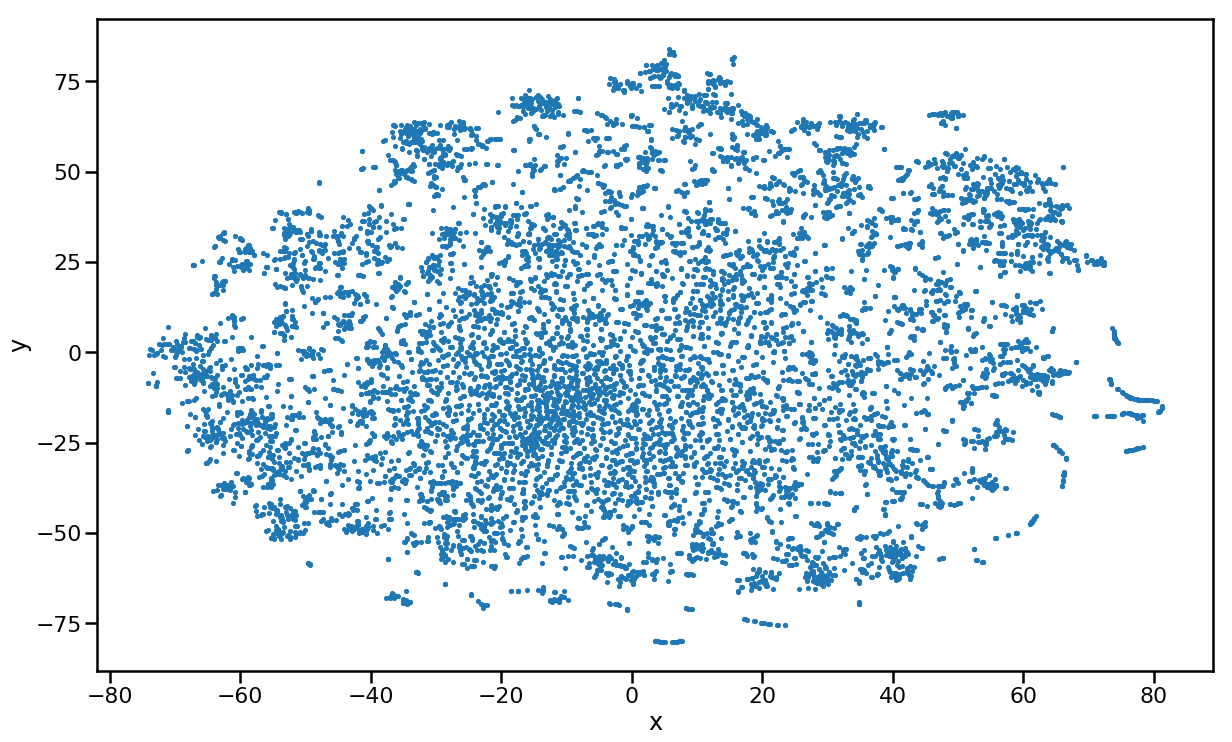

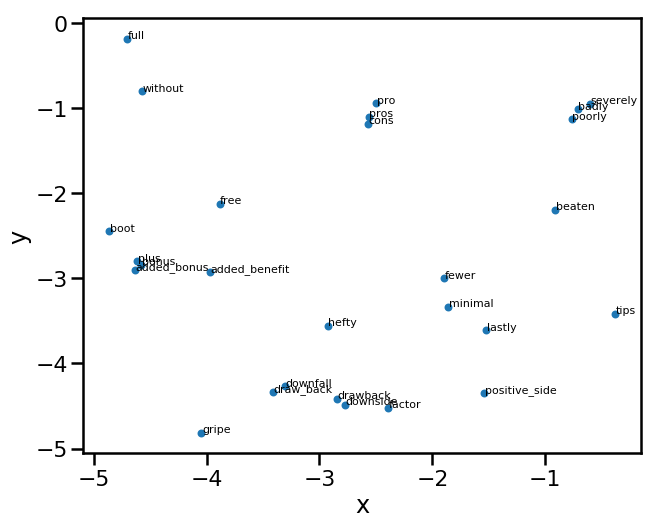

In [6]:
#Plot our word vectors in a "poster"
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

#Zoom in function
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) 
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
        
#Zoom in
plot_region(x_bounds=(-5, 0), y_bounds=(-5, 0))

#Most common words
w2v_model.most_similar("food")